In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_json('elcinema_full.json')

In [3]:
df['IYWR'] = df['IYWR'].apply(lambda x: pd.DataFrame(x))
df['Year'] = df['IYWR'].apply(lambda x: x['Year'][0])
df['Total Adj'] = df['Total Adj'].apply(lambda x: int(x))

In [4]:
inf = pd.read_csv('inf.csv')
inf = inf.iloc[[65]]
inf = inf.iloc[:,5:-1]
inf['2020'] = 5.68212402
inf = pd.DataFrame.from_dict({'Year':list(inf.columns), 'Rate':inf.values.reshape(-1)})
inf.index = range(1961,2021)
inf.drop('Year', axis=1, inplace=True)
adjust_inflation = lambda df: int(df['Total Revenue']*inf.loc[df['Year']:]['Rate'].apply(lambda x: 0.01*x+1).agg('prod'))

In [5]:
def count(item, dd):
    if item==None:
        return None
    for name in item:
        try:
            dd[name] +=1
        except KeyError:
            dd[name] = 1
    return None

def var(row, col, ss):
    y=df['Total Adj'].agg('mean')
    for actor in row[col]:
        ss.loc[actor, 'VAR'] += row['Total Adj']/y


def query1(col='Cast', df=df, year=2011, thr=1):
    df = df[df[col].notna()][ df['Year'] >= year ]
    dd = {}
    df[col].apply(count, dd=dd)
    dd = {'Name':dd.keys(), 'Movies':dd.values()}
    ss = pd.DataFrame(dd, columns=['Name', 'Movies'] )
    ss.sort_values('Movies', ascending=False, inplace=True)
    ss.index = ss['Name']
    ss['VAR'] = 0
    df.apply( var , col=col, ss=ss, axis=1 )
    ss['VAR'] /= ss['Movies']
    ss['VAR'] = ss['VAR'].apply(lambda x: round(x, 2))
    ss.sort_values('VAR', ascending=True, inplace=True, ignore_index=False)
    ss = ss[ ss['Movies']>thr ]
    ss['Index'] = range(len(ss))
    return ss

person_m_rev = lambda nam, col: df[df.apply(lambda x: True if nam in x[col] else False, axis=1)][['Total Adj', 'Year']]

def yr_person(name, col, yr=2010):
    prs = person_m_rev(name, col)
    prs = prs[ prs['Year']<=yr ]
    out = prs['Total Adj'].agg('mean')
    if pd.isnull(out):
        return 0
    else:
        return out

def compare(col='Director', year=2011, df=df, threshold=2, stop=10):
    res = query1(col, df, year, threshold)
    names = res['Name'][-stop:].values
    plt.figure(figsize=(25,10))
    plt.grid(True)
    plt.xticks(range(year,2022))
    for name in names:
        plt.plot(range(year,2022) ,[yr_person(name, col, year)/1000000 for year in range(year,2022)], label=name, linewidth=3,marker='o', markersize=8)
    plt.xlabel('Year')
    plt.ylabel('Mean Revenue - Adjusted for Inflation (millions)')
    plt.legend()
    plt.show()

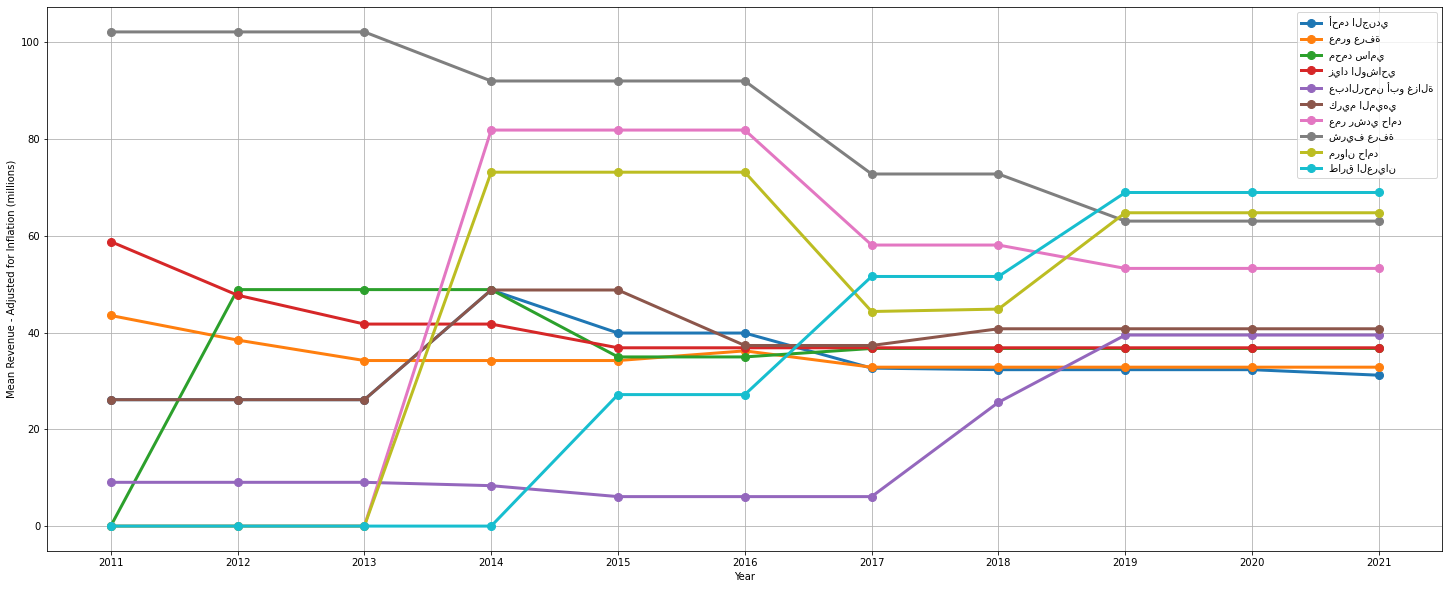

In [6]:
compare('Director', 2011, df, 3, 10)

In [585]:
#res = query1('Director', df, 2011, 2)
#res1 = query1('Cast', df, 2011, 4)
#res2 = query1('Writer', df, 2011, 2)
#res3 = query1('Genre', df, 2011, 2)
#res3.tail(5)
#names = res3['Name'][-10:].values
#names 